In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [3]:
def abline(slope, intercept, color='red'):
    """Plot a line from slope and intercept - improved from https://stackoverflow.com/a/43811762"""
    axes = plt.gca()
    xrng = axes.get_xlim()
    yrng = axes.get_xlim()
    yrng2 = ((yrng[1]-intercept)/slope, (yrng[0]-intercept)/slope)
    x_vals = [max(xrng[0], min(yrng2)), min(max(yrng2), xrng[1])]
    x_vals = np.array(x_vals)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

In [4]:
def draw_boundary(m):
    """ 
    extract and draw decision boundary from LogisticRegression.
    This is easy to calculate in two dimensions, higher dims require triangular solve.   
    """
    
    def _draw_boundary(coeffs, intercept, title=True):
        a = -coeffs[0]/coeffs[1]
        b = -intercept/coeffs[1]
        abline(a,b, 'grey')
        if title:
            plt.title('Slope = {:.2f}'.format(a))    
    _draw_boundary(m.coef_[0], m.intercept_[0])

In [8]:
def generate_2class_data(draw=True, lreg=True, fighandle=None):
    """
    1) Generate two classes of data (Gaussians centered at fixed mu (`centers`) and sd)
    2) Draw scatter plot
    3) Fit logistic regression (if lreg) and plot boundary
    
    """
    data_class1 = np.random.randn(n,2)*sd + centers[0]
    data_class2 = np.random.randn(n,2)*sd + centers[1]
    data_all = np.concatenate((data_class1, data_class2), 0)

    lbls = np.concatenate((np.zeros(200), np.ones(200))).astype(int)
    lblcol = [cm.Set1.colors[l] for l in lbls]
    if draw:
        if fighandle is None:
            fighandle = plt.figure()
            fighandle.add_subplot(1,1,1)
        ax = fighandle.axes[0]
        ax.cla
        ax.scatter(data_all[:,0], data_all[:,1], c=lblcol, alpha=0.7)
    if lreg:
        lmodel = LogisticRegression()
        lmodel.fit(data_all, lbls)
        draw_boundary(lmodel)
        
    return data_all, lbls, lblcol

## Discriminative Approach
In this example we use logistic regression. We have not covered this yet in the ADS course, and we do not expect you to understand it at this stage - it is simply a linear boundary separating two classes. I hope it is nevertheless intuitive enough

In [9]:
n = 200
sd = 0.5
centers = [np.array([1,0.5]), np.array([-1,-1])]

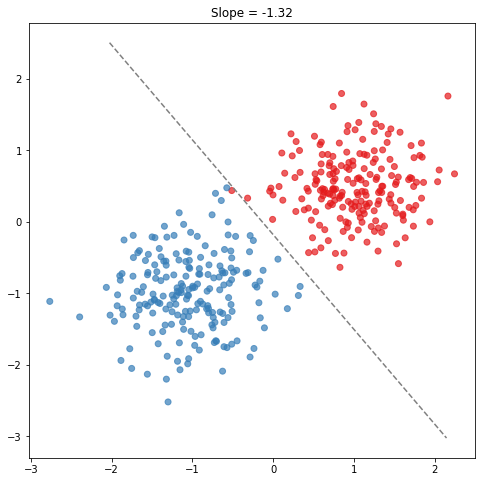

In [11]:
f=plt.figure(figsize=(8,8))
f.add_subplot(1,1,1)
generate_2class_data(draw=True, lreg=True, fighandle=f);

## Generative Approach
In this example we use an even more sophisticated algorithm -- which we will not cover in this course. The below models each class as forming its own cluster in input space and then using Bayes rule to calculate the class probabilities conditioned on input data. The approach below is actually not using a Gaussian assumption; it is approximately equivalent to modelling the class densities as kernel densities with a small but non-zero probability elsewhere

Understanding the concept demonstrated here is all I'm hoping to achieve.

In [12]:
x, y, lblcols = generate_2class_data(draw=False, lreg=False, fighandle=None)

Generative models also build a model of the input space too, i.e. a joint model of both the input variables and the target variables is built. They perform a kind of 'statistical inversion' which allows prediction of the targets given the inputs. This is extra effort, and more statistical strength can be used to model the target relationship if the distribution of the $x$'s is ignored. However, there are advantages of doing so:

1. Missing values can be imputed as part of the model fitting procedure. NaN values are not a problem.
2. Generative models provide a likelihood for test input data which can indicate how similar they are to data in the training set. This is a good proxy for uncertainty and anomaly.
3. Synthetic data can be generated or 'hallucinated' from the model since they define a complete model from input space to output space.

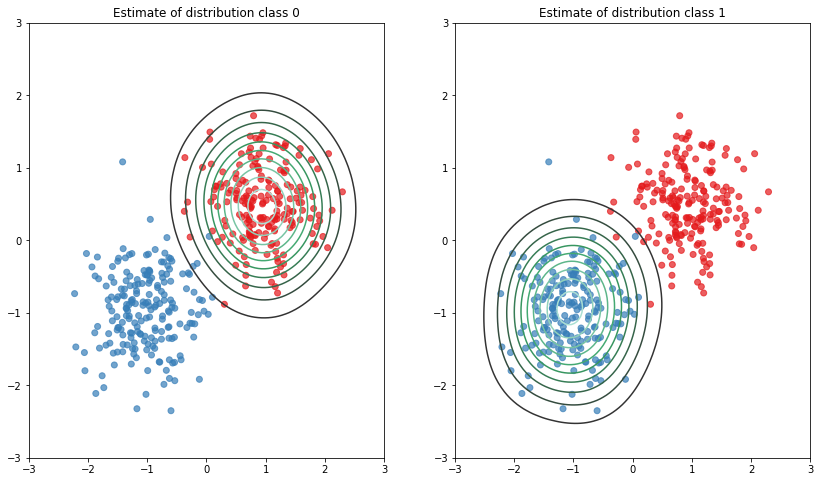

In [13]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches(14, 8)

for i, ax, sl in zip(range(2), [ax1, ax2], [slice(0,200), slice(200,400)]):
    ax = sns.kdeplot(x[sl,0],x[sl,1], bw=0.5, ax=ax)
    ax.scatter(x[:,0],x[:,1],c=lblcols, alpha=0.7)
    ax.set_title('Estimate of distribution class {:d}'.format(i))
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])

In [14]:
import GPy
num_inducing = 200
# Create GP model
m = GPy.models.SparseGPClassification(x, y[:,None], num_inducing=num_inducing)
m['.*len'] = 10.

# Optimize
m.optimize(messages=1)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s07  0014   2.742123e+01   1.984267e+01 
    01s75  0024   2.589963e+01   9.634718e-11 
Runtime:     01s75
Optimization status: Converged



In [15]:
# create grid for heatmap
n_grid = 500
min_x      = np.array([-4,-4])
max_x      = np.array([3,3])
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))

In [16]:
#Test
probs = m.predict(Xgrid)[0]

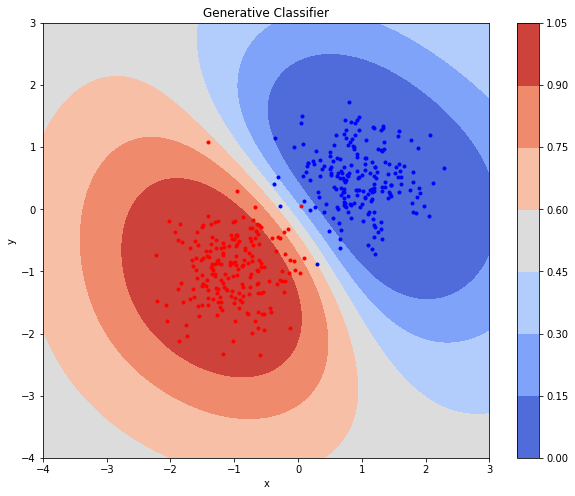

In [17]:
plt.figure(figsize=(10,8))
plt.contourf(X1,X2,np.reshape(probs,(n_grid,n_grid)),
             cmap=cm.coolwarm)
plt.plot(x[y==0,0],x[y==0,1],"bo", markersize = 3)
plt.plot(x[y==1,0],x[y==1,1],"ro", markersize = 3)
plt.colorbar()
plt.title("Generative Classifier")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [ ]:
from plotly import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

z_grid = np.concatenate((Xgrid, probs), 1)

data = [
    go.Surface(
        x=X1, y=X2,
        z=probs.reshape(n_grid, n_grid)
    )
]
layout = go.Layout(
    title='Generative Model',
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

trace1 = go.Figure(data=data, layout=layout)
iplot(trace1, layout)